<h1><center>Physique numérique (PHY-3500) - TP2</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [2]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from sympy import symbols, solve, sqrt
from scipy.misc import derivative


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Numéro 1

A) *À l’aide des équations (2.1.2) et (2.1.3), démontrez que les matrices de réflexion $\boldsymbol{Q_i}$ sont orthogonales.*

Pour que la les matirces $\boldsymbol{Q_i}$ soient orthogonales, il faut que:
\begin{align*}
    Q_i^tQ_i &= Q_iQ_i^{-1} = I
    \\ \\
    Q_i^tQ_i&=
    \begin{bmatrix}
        I_i & 0\\
        0 & H_{m,i}^t\\
    \end{bmatrix}
    \begin{bmatrix}
        I_i & 0\\
        0 & H_{m,i}\\
    \end{bmatrix}
    \\
    &=\begin{bmatrix}
        I_i^2 & 0\\
        0 & H_{m,i}^tH_{m,i}\\
    \end{bmatrix}
    \\
    &=\begin{bmatrix}
        I_i & 0\\
        0 & H_{m,i}^tH_{m,i}\\
    \end{bmatrix}
\end{align*}

Ce résultat est obtenu en utilisant la forme générale du produit
de matrices par blocs. Ainsi, il faut que $H_{m,i}$ soit orthogonale pour que $Q_i$ le soit aussi, car $H_{m,i}^tH_{m,i}$ doit valoir l'identité. Donc, calculons $H_{m,i}^tH_{m,i}$:
\begin{align*}
    H_{m,i}^tH_{m,i} &= \left(I-2\frac{vv^t}{v^tv}\right)^t\left(I-2\frac{vv^t}{v^tv}\right)
\end{align*}
En considérant 2.1.4, le produit $v^tv$ donne un scalaire, et donc, posons $\frac{2}{v^tv}=C$. Ainsi:
\begin{align*}
    H_{m,i}^tH_{m,i} &= \left(I-Cvv^t\right)^t\left(I-Cvv^t\right)
    \\
    &= \left(I^t-C(v^t)^tv^t\right)\left(I-Cvv^t\right)
    \\
    &= \left(I-Cvv^t\right)\left(I-Cvv^t\right)
    \\
    &= I^2-CIvv^t-Cvv^tI+C^2vv^tvv^t
    \\
    &= I-2Cvv^t+C^2v(v^tv)v^t
    \\
    &= I-2Cvv^t+C^2v\frac{2}{C}v^t
    \\
    &= I-2Cvv^t+2Cvv^t
    \\
    &= I
\end{align*}
Il est important de noter que nous avons aussi pu observer que $H_{m,i}^t=H_{m,i}$ $Q_i=Q_i^t$ lors de ce cheminement. Puisque $H_{m,i}$ est bel et bien orthogonale, $Q_i$ vaut l'identité.
\begin{align*}
    &=\begin{bmatrix}
        I_i & 0\\
        0 & H_{m,i}^tH_{m,i}\\
    \end{bmatrix}
    \\
    &=\begin{bmatrix}
        I_i & 0\\
        0 & I_{m-i}\\
    \end{bmatrix}
    \\
    &=I_m \text{ CQFD}
\end{align*}

B) *Démontrez l’équation (2.1.5) et que la matrice $\boldsymbol{Q}$ est orthogonale.*

Débutons en revenant à la définition donnée dans les notes de cours de la décomposition QR. Pour la suite, assumons que la matrice Q est inversible:
\begin{align*}
    A&=QR
    \\
    Q^{-1}A &= R
    \\
    \longrightarrow Q^{-1} &= Q_{n-1}Q_{n-2}...Q_1Q_0 \text{ (selon l'équation 2.1.1)}
\end{align*}

En sachant cette égalité, retrouvons l'équation (2.1.5), sachant que les matrices $Q_i$ sont orthogonales:
\begin{align*}
    (Q^{-1})^{-1} &= (Q_{n-1}Q_{n-2}...Q_1Q_0)^{-1}
    \\
    Q &= Q_0^{-1}Q_1^{-1}...Q_{n-2}^{-1}Q_{n-1}^{-1}
    \\
    Q &= Q_0^tQ_1^t...Q_{n-2}^tQ_{n-1}^t \text{ CQFD}
\end{align*}
Maintenant, démontrons que la matrice $Q$ est orthogonale en montrant que $Q^{-1} = Q^t$:
\begin{align*}
    Q^t &= (Q_0^tQ_1^t...Q_{n-2}^tQ_{n-1}^t)^t
    \\
    Q^t &= Q_{n-1}Q_{n-2}^t...Q_1Q_0
    \\
    Q^t &= Q^{-1} \text{ CQFD}
\end{align*}


C) *Implémentez la fonction householder_qr qui prend en argument une matrice $\boldsymbol{A}$ et qui retourne les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues par la méthode de Householder.*

In [2]:
def householder_qr(
    A: NDArray,
    progress: bool = False,
) -> tuple[NDArray, NDArray]:
    """Calcule la décomposition QR d'une matrice par la méthode de Householder.

    Paramètres
    ----------
    A
        Matrice à décomposer.
    progress
        Affiche progressivement la matrice Q si True.

    Retours
    -------
    Q
        Matrice orthogonale Q.
    R
        Matrice triangulaire supérieure R.

    """
    m, n = A.shape

    # Initialise Q en tant que matrice identité
    Q = np.eye(m)

    # Initialise R comme une copie de A avec le type de données float
    R = np.copy(A).astype(float)

    # Exclut la dernière itération car Q n'a pas besoin de modifications
    # supplémentaires
    for j in range(min(m - 1, n)):
        # Calcule du vecteur de réflexion de Householder
        x = R[j:, j]
        e = np.zeros_like(x)
        x_norm = np.linalg.norm(x)
        e[0] = x_norm
        v = np.sign(x[0]) * x_norm * np.eye(len(x))[0] + x
        v /= np.linalg.norm(v)

        # Applique la réflexion de Householder à R
        R[j:, :] -= 2 * np.outer(v, (v @ R[j:, :]))

        # Appliquer la transformation de Householder sur Q
        Q[j:, :] -= 2 * np.outer(v, (v @ Q[j:, :]))

        if progress is True:
            print(f"Matrice R à l'étape {j} :\n{R.round(3)}\n")

            # Vérification de l'orthogonalité de Q
            is_ortho = np.allclose(np.eye(Q.shape[0]), Q @ Q.T)
            print(f"Q est orthogonale à l'étape {j}: {is_ortho}")

            # Vérification de la triangularité supérieure de R
            is_triu = np.allclose(np.triu(R), R)
            print(f"R est triangulaire supérieure à l'étape {j}: {is_triu}\n")

    # Utiliser np.triu pour obtenir la matrice triangulaire supérieure
    R = np.triu(R)
    return Q.T, R

D) *À l’aide d’une matrice de dimension 4 × 3 de votre choix, testez votre fonction householder_qr et comparez les résultats obtenus avec ceux obtenus à l’aide de la fonction* `numpy.linalg.qr`. *Les matrices sont-elles exactement les mêmes ? Si non, est-ce un problème ?*

In [3]:
# Fixer un "seed" pour avoir une séquence de nombres aléatoire et reproductible
np.random.seed(42)

# Tester la fonction householder_qr avec une matrice aléatoire 4 x 3
A = np.random.rand(4, 3)
Q, R = householder_qr(A)
print("\033[1mDécomposition QR de householder_qr :\033[0m")
print(f"Q :\n{Q}\nR :\n{R}")

# Comparaison avec la décomposition QR de numpy
Q_np, R_np = np.linalg.qr(A, mode="complete")
print("\033[1m\nDécomposition QR de numpy.linalg.qr :\033[0m")
print(f"Q :\n{Q_np}\nR :\n{R_np}\n")

# Différence moyenne entre QR de householder_qr et QR de np.linalg.qr
Q_diff = np.abs(Q - Q_np)
R_diff = np.abs(R - R_np)
print("\033[1mDifférence moyenne des coefficients :\033[0m")
print(f"Q : {Q_diff.mean()}\nR : {R_diff.mean()}")

Décomposition QR de householder_qr :
Q :
[[-0.37390264  0.63777869 -0.08901388 -0.66746662]
 [-0.59763955 -0.12681728 -0.72814804  0.31071655]
 [-0.05798475  0.70307946  0.21352505  0.67581366]
 [-0.70686742 -0.28781069  0.64520076  0.03492047]]
R :
[[-1.00170493 -0.51349302 -1.08737614]
 [ 0.          1.18962568  0.59054853]
 [ 0.          0.          0.57539496]
 [ 0.          0.          0.        ]]

Décomposition QR de numpy.linalg.qr :
Q :
[[-0.37390264  0.63777869 -0.08901388 -0.66746662]
 [-0.59763955 -0.12681728 -0.72814804  0.31071655]
 [-0.05798475  0.70307946  0.21352505  0.67581366]
 [-0.70686742 -0.28781069  0.64520076  0.03492047]]
R :
[[-1.00170493 -0.51349302 -1.08737614]
 [ 0.          1.18962568  0.59054853]
 [ 0.          0.          0.57539496]
 [ 0.          0.          0.        ]]

Différence moyenne des coefficients :
Q : 2.0036056147532122e-16
R : 9.251858538542972e-17


Les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues à partir de la décomposition $QR$ de la fonction householder_qr ne sont pas exactement les mêmes que celles produites par la fonction `numpy.linalg.qr`. Cependant, cela n'est pas nécessairement un problème, car la décomposition $QR$ n'est pas unique. Il existe plusieurs façons de décomposer une matrice en une matrice orthogonale $\boldsymbol{Q}$ et une matrice triangulaire supérieure $\boldsymbol{R}$, et différentes implémentations peuvent utiliser des méthodes différentes pour parvenir à cette décomposition.

Les différences entre les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ peuvent provenir de la manière dont les calculs sont effectués, des algorithmes utilisés et des conventions de signe adoptées. Si NumPy utilise plutôt la méthode de Gram-Schmidt par exemple, alors les résultats seront légèrment différents de ceux que nous avons calculés avec la fonction householder_qr. Cependant, tant que les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ produites par les deux fonctions sont proches ou suffisamment similaires, elles fournissent toutes deux une décomposition $QR$ valide de la matrice d'entrée. Comme la différence absolue entre les deux fonctions est de l'ordre de $10^{-16}$, tant pour $\boldsymbol{Q}$ que pour $\boldsymbol{R}$, il est juste d'affirmer que les résultats sont similaires.

E) *À l’aide de la matrice utilisée en D, illustrez comment la multiplication successive des matrices $\boldsymbol{Q_i}$ triangularise progressivement la matrice $\boldsymbol{A}$. Dans l’élan, assurez-vous que les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues sont bien orthogonale et triangulaire supérieure, respectivement.*

In [4]:
# Affichage de la matrice A
print(f"\033[1mMatrice A :\033[0m\n{A}\n")

# Affichage des matrices Q et R en affichant la progression
Q, R = householder_qr(A, progress=True)

Matrice A :
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]]

Matrice R à l'étape 0 :
[[-1.002 -0.513 -1.087]
 [-0.    -0.481 -0.635]
 [-0.     0.804  0.524]
 [-0.    -0.733  0.034]]

Q est orthogonale à l'étape 0: True
R est triangulaire supérieure à l'étape 0: False

Matrice R à l'étape 1 :
[[-1.002 -0.513 -1.087]
 [ 0.     1.19   0.591]
 [-0.    -0.    -0.066]
 [-0.     0.     0.572]]

Q est orthogonale à l'étape 1: True
R est triangulaire supérieure à l'étape 1: False

Matrice R à l'étape 2 :
[[-1.002 -0.513 -1.087]
 [ 0.     1.19   0.591]
 [-0.     0.     0.575]
 [-0.    -0.     0.   ]]

Q est orthogonale à l'étape 2: True
R est triangulaire supérieure à l'étape 2: True



# Numéro 2

A) *Modifiez votre code de décomposition QR pour qu’il retourne la décomposition QR réduite de la matrice d’entrée lorsque l’argument additionnel reduite=True lui est passé.*

In [5]:
def householder_qr(
    A: NDArray,
    progress: bool = False,
    reduite: bool = False,
) -> tuple[NDArray, NDArray]:
    """Calcule la décomposition QR d'une matrice par la méthode de Householder.

    Paramètres
    ----------
    A
        Matrice à décomposer.
    progress
        Affiche progressivement la matrice Q si True.
    reduite
        Indique si la décomposition QR réduite doit être retournée (par défaut False).

    Retours
    -------
    Q
        Matrice orthogonale Q.
    R
        Matrice triangulaire supérieure R.

    """
    m, n = A.shape

    # Initialise Q en tant que matrice identité
    Q = np.eye(m)

    # Initialise R comme une copie de A avec le type de données float
    R = np.copy(A).astype(float)

    # Exclut la dernière itération car Q n'a pas besoin de modifications
    # supplémentaires
    for j in range(min(m - 1, n)):
        # Calcule du vecteur de réflexion de Householder
        x = R[j:, j]
        e = np.zeros_like(x)
        x_norm = np.linalg.norm(x)
        e[0] = x_norm
        v = np.sign(x[0]) * x_norm * np.eye(len(x))[0] + x
        v /= np.linalg.norm(v)

        # Applique la réflexion de Householder à R
        R[j:, :] -= 2 * np.outer(v, (v @ R[j:, :]))

        # Appliquer la transformation de Householder sur Q
        Q[j:, :] -= 2 * np.outer(v, (v @ Q[j:, :]))

        if progress is True:
            print(f"Matrice R à l'étape {j} :\n{R.round(3)}\n")

            # Vérification de l'orthogonalité de Q
            is_ortho = np.allclose(np.eye(Q.shape[0]), Q @ Q.T)
            print(f"Q est orthogonale à l'étape {j}: {is_ortho}")

            # Vérification de la triangularité supérieure de R
            is_triu = np.allclose(np.triu(R), R)
            print(f"R est triangulaire supérieure à l'étape {j}: {is_triu}\n")

    Q = Q.T

    # Utiliser np.triu pour obtenir la matrice triangulaire supérieure
    R = np.triu(R)

    # Tronquer pour obtenir la décomposition QR réduite
    if reduite is True:
        R = R[:n, :n]
        Q = Q[:, :n]
    return Q, R

B) *Utilisez votre code pour résoudre approximativement l’équation (2.2.4). Vous utiliserez les données fournies dans le fichier bataille_navale_equipeXX.csv où vous remplacerez XX par votre numéro d’équipe dans la boîte de dépôt sur MonPortail.*

In [6]:
datapath = "Data/bataille_navale_equipe04.csv"
xi, yi = np.genfromtxt(datapath, delimiter=",", skip_header=1, unpack=True)
X = np.ones((xi.size, 3))
X[:, 1] = xi
X[:, 2] = xi**2

# Calculer la décomposition QR réduite avec la fonction householder_qr
Q, R = householder_qr(X, reduite=True)

# Transformer yi en B en utilisant Q^T pour avoir une équation Ax = B
B = Q.T @ yi

# Résoudre Xα = Y pour α
alpha_r = np.linalg.solve(R[:R.shape[1]], B[:R.shape[1]])
print(f"Coefficients \u03B1 avec la décomposition QR réduite :\n{alpha_r}\n")

Coefficients α avec la décomposition QR réduite :
[ 2.41719743e+02  1.99814880e+00 -7.91455411e-04]



C) *Tracez les données (cercles noirs) et la solution estimée de la trajectoire (ligne pleine de la couleur de votre choix) donnée par l’équation (2.2.3).*

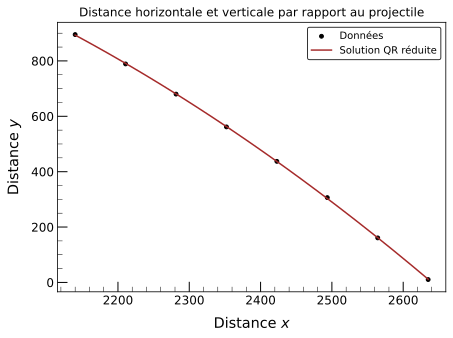

In [7]:
x_gen = np.linspace(xi.min(), xi.max(), 1000)

# Inverser la matrice de coefficients α et utiliser np.polyval
alpha_r = np.flip(alpha_r)

# Calculer la série de puissance y(x) = α_0 + α_1x + α_2x^2
y = np.polyval(alpha_r, x_gen)

plt.scatter(xi, yi, color="k", s=15, label="Données")
plt.plot(x_gen, y, color="brown", label="Solution QR réduite")
plt.title("Distance horizontale et verticale par rapport au projectile")
plt.xlabel("Distance $x$")
plt.ylabel("Distance $y$")
plt.legend()
plt.show()

D) *Obtenez la position d’impact du projectile (à $y = 0$) en résolvant l’équation quadratique (2.2.3) pour $x$ à l’aide d’une implémentation personnelle de la méthode de la bissection. Comparez votre solution avec celle obtenue en résolvant cette même équation analytiquement. Considérant que votre embarcation se situe à la position ($x$, $y$) = (0, 0), quelle est la distance horizontale vous séparant du point d’impact ?*

In [8]:
def bisection(
    coeffs: NDArray,
    a: float,
    b: float,
    tol: float = 1e-8,
    max_n: int = 1000,
) -> float:
    """Calcul la racine d'un polynôme par la méthode de la bissection.

    Paramètres
    ----------
    coeffs
        Les coefficients du polynôme, du terme de plus haut degré
        au terme de plus bas degré.
    a
        La borne inférieure de l'intervalle de recherche.
    b
        La borne supérieure de l'intervalle de recherche.
    tol : optionnel
        La tolérance pour la convergence de la méthode (par défaut 1e-6).
    max_n : optionnel
        Le nombre maximal d'itérations pour la méthode (par défaut 1000).

    Retourne
    --------
    c
        La valeur de la racine du polynôme trouvée dans l'intervalle [a, b].

    Soulève
    -------
    ValueError
        Si les bornes [a, b] ne sont pas valides ou si la méthode ne converge
        pas dans le nombre maximal d'itérations.

    """
    # Définir l'équation quadratique à résoudre
    func = lambda x: np.polyval(coeffs, x)

    # Vérifier si les bornes fournies encadrent une racine
    if func(a) * func(b) >= 0:
        raise ValueError(
            "Les bornes n'encadrent pas une racine ou en encadrent plusieurs."
        )

    # Algorithme de la méthode de la bissection
    for _ in range(max_n):
        # Calcul du point milieu
        c = (a + b) / 2

        # Vérifier si la racine a été trouvée avec une tolérance donnée
        if (b - a) / 2 < tol:
            return c

        # Mettre à jour les bornes selon le signe de la fonction au point milieu
        if func(c) * func(a) < 0:
            b = c
        else:
            a = c

    # Si aucune solution n'a été trouvée dans le nombre maximal d'itérations
    raise ValueError("La méthode de la bissection n'a pas convergé.")


# Calcul de la racine de l'équation quadratique avec la méthode de la bissection
x_impact = bisection(alpha_r, a=2600, b=2700)
print(f"Position d'impact du projectile (à y = 0) : x \u2248 {x_impact}")

Position d'impact du projectile (à y = 0) : x ≈ 2640.323217603145


# Numéro 3

A) *Trouvez analytiquement toutes les solutions de l’équation cubique (2.3.3).*

Dans cette partie, nous tentons de résoudre analytiquement l'équation du modèle SIR sur réseau, qui permet de comprendre la dynamique de la propagation d'une maladie dans une population. L'équation en question est :

$$u = \frac{1}{[1 + T(\kappa - 1)(1 - u)]^2}$$

où $u$ est la fraction de la population qui sera infectée à un moment donné, $T$ est la probabilité de transmission, et $\kappa$ est le nombre moyen de contacts.

Pour simplifier l'équation et éliminer le dénominateur, nous multiplions chaque côté de l'équation par le carré du dénominateur et remplaçons $\kappa$ par 5:

$$u[1 + 4T(1 - u)]^2 = 1$$

L'étape suivante consiste à développer le carré sur le côté gauche de l'équation. La simplification de l'expression donne le résultat suivant :

$$  u^3[16T^2] + u^2[-32T^2 - 8T] + u[16T^2 + 8T + 1]    - 1 = 0 $$

In [2]:
# Définition des symboles
u, T, kappa = symbols('u T kappa')

# Définition de l'équation à résoudre
equation = u**3 * (16*T**2) + u**2 * ( -32*T**2 - 8*T ) + u * (8*T + 16*T**2 + 1) - 1

# Résolution de l'équation pour u
solutions = solve(equation, u)

# Affichage des solutions
for solution in solutions:
    display(solution)

1

(2*T**2 + T - 2*sqrt(T**4 + T**3))/(4*T**2)

(2*T**2 + T + 2*sqrt(T**4 + T**3))/(4*T**2)

Les solutions possibles de l'équation sont donc :

1. $$u = 1 $$

2. $$u = \frac{2T^2 +T -2 \sqrt{T^4 + T^3}}{4T^2} $$

3. $$u = \frac{2T^2 +T +2 \sqrt{T^4 + T^3}}{4T^2} $$

B) *Démontrez laquelle des solutions obtenues précédemment (ou une combinaison de celles-ci) correspond à $u$, soit la solution recherchée de l’équation (2.3.3).*

## Analyse des Solutions

La première solution, \(u = 1\), est une solution triviale qui implique que \(R∞ = 0\), ce qui veut dire que la contagion est nulle. 

Les deux autres solutions nécessitent une évaluation plus détaillée pour déterminer leur validité et leur applicabilité. Sachant que u doit être strictement plus grand que 0 et que $R_\infty$ doit se situer entre 0 et 1 :

Intervalles valides pour R_infini avec u1: [(0.001, 1.0)]
Intervalles valides pour R_infini avec u2: [(0.125, 1.0)]
Intervalles valides pour R_infini avec u3: []


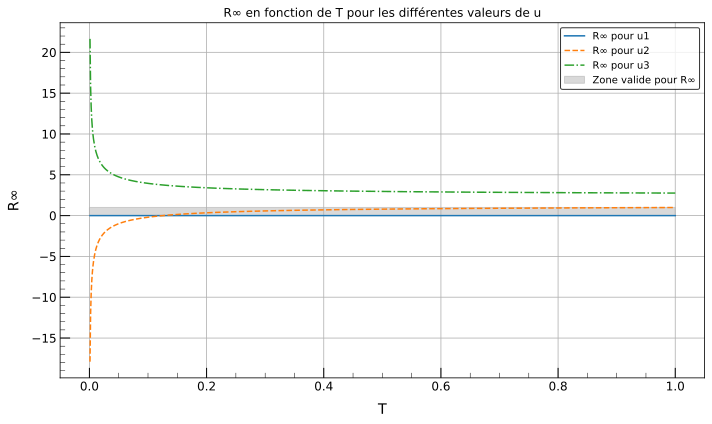

In [3]:
# Générer un ensemble de valeurs de T
T_values = np.linspace(0.001, 1, 1000)  # Éviter T = 0 pour la division par zéro

# Calcul de u1, u2, u3 et vérification que u est strictement positif
u1_values = np.ones_like(T_values)  # u1 est toujours 1, donc toujours > 0
u2_values = (2*T_values**2 + T_values - 2 * np.sqrt(T_values**4 + T_values**3)) / (4*T_values**2)
u3_values = (2*T_values**2 + T_values + 2 * np.sqrt(T_values**4 + T_values**3)) / (4*T_values**2)

# Calcul de R_infini pour u1, u2, et u3
def R_infini_numpy(T, u):
    return 1 - (1 - T*(1 - u)) / (1 + 4*T*(1 - u))

R_infini_u1_values = R_infini_numpy(T_values, u1_values)
R_infini_u2_values = R_infini_numpy(T_values, u2_values)
R_infini_u3_values = R_infini_numpy(T_values, u3_values)

# Fonction pour trouver les intervalles valides où R_infini est entre 0 et 1 et u > 0
def trouver_intervalles_valides(T_values, R_values, u_values):
    masque_valide = (R_values >= 0) & (R_values <= 1) & (u_values > 0)
    changements = np.diff(masque_valide.astype(int))
    debuts = T_values[np.where(changements == 1)[0] + 1]
    fins = T_values[np.where(changements == -1)[0]]
    if masque_valide[0]:  # Ajouter le début si le premier élément est valide
        debuts = np.insert(debuts, 0, T_values[0])
    if masque_valide[-1]:  # Ajouter la fin si le dernier élément est valide
        fins = np.append(fins, T_values[-1])
    return list(zip(debuts, fins))

# Trouver et afficher les intervalles valides
intervalles_valides_R_infini_u1 = trouver_intervalles_valides(T_values, R_infini_u1_values, u1_values)
intervalles_valides_R_infini_u2 = trouver_intervalles_valides(T_values, R_infini_u2_values, u2_values)
intervalles_valides_R_infini_u3 = trouver_intervalles_valides(T_values, R_infini_u3_values, u3_values)

print("Intervalles valides pour R_infini avec u1:", intervalles_valides_R_infini_u1)
print("Intervalles valides pour R_infini avec u2:", intervalles_valides_R_infini_u2)
print("Intervalles valides pour R_infini avec u3:", intervalles_valides_R_infini_u3)


# Visualisation de R_infini en fonction de T pour les 3 valeurs de u
plt.figure(figsize=(10, 6))
plt.plot(T_values, R_infini_u1_values, label='R∞ pour u1')
plt.plot(T_values, R_infini_u2_values, label='R∞ pour u2', linestyle='--')
plt.plot(T_values, R_infini_u3_values, label='R∞ pour u3', linestyle='-.')
# Ajout du carré gris pour la zone valide de R_infini
plt.fill_between([0, 1], 0, 1, color='grey', alpha=0.3, label='Zone valide pour R∞')
plt.title('R∞ en fonction de T pour les différentes valeurs de u')
plt.xlabel('T')
plt.ylabel('R∞')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

- **Solution 1**: Elle est jugée appropriée pour les cas où la probabilité de transmission de l'infection reste en dessous de 0.125.

- **Solution 2**: Cette solution est considérée comme pertinente pour des situations où la probabilité qu'un individu infectieux transmette la maladie à ses contacts est au-delà de 0.125.

- **Solution 3**: La troisième solution, en revanche, ne produit aucune valeur valide de qui respecte les contraintes du problème.

La solution optimale à notre problème semble être une combinaison des solutions 1 et 2, adaptée en fonction de la valeur du paramètre T. Pour des valeurs inférieures à 0.125, la solution 1 est pertinente, offrant une modélisation valide de la dynamique de transmission. Lorsque T dépasse le seuil de 0.125, c'est la solution 2 qui devient adéquate, reflétant avec précision le comportement de transmission dans ces conditions. La solution 3 ne fournit aucune contribution valable compte tenu des contraintes spécifiées par le modèle.

C) *Tracez $R_\infty$ en fonction de $T$ et identifiez tout changement qualitatif de $R_\infty$. Comment interprétez-vous ce changement (ou cette absence de changement) ?*

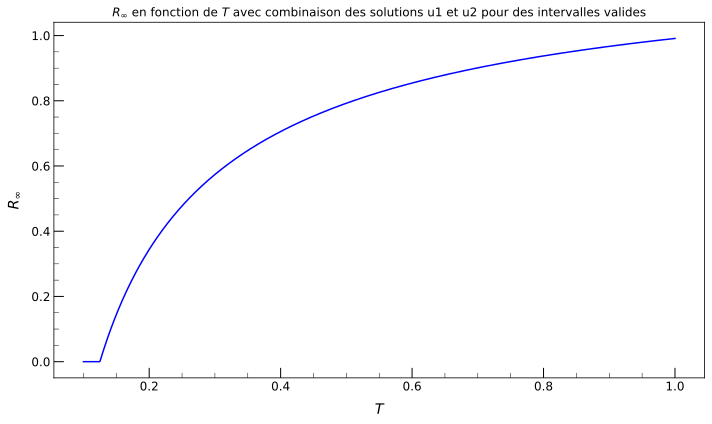

In [4]:
# Générer un ensemble de valeurs de T
T_values = np.linspace(0.1, 1, 1000)

# Calcul de u1, u2
u1_values = np.ones_like(T_values)  # u1 est constamment 1
u2_values = (2*T_values**2 + T_values - 2 * np.sqrt(T_values**4 + T_values**3)) / (4*T_values**2)

# Fonction pour calculer R_infini directement à partir des valeurs de u
def R_infini_numpy(T, u):
    return 1 - (1 - T*(1 - u)) / (1 + 4*T*(1 - u))

# Calcul de R_infini pour u1, u2
R_infini_u1_values = R_infini_numpy(T_values, u1_values)
R_infini_u2_values = R_infini_numpy(T_values, u2_values)

# Condition pour changer de u1 à u2 basé sur la validité de R_infini_u2
# Par exemple, basculer à u2 lorsque R_infini_u2 devient valide
R_infini_combiné = np.where(R_infini_u2_values > 0, R_infini_u2_values, R_infini_u1_values)

# Tracer R_infini combiné
plt.figure(figsize=(10, 6))
plt.plot(T_values, R_infini_combiné, color='blue')
plt.xlabel('$T$')
plt.ylabel('$R_{\infty}$')
plt.title('$R_{\infty}$ en fonction de $T$ avec combinaison des solutions u1 et u2 pour des intervalles valides')
plt.show()

### Interprétation des changements

- **T entre 0 et 0.125** : Le saut initial à environ 0.125 pourrait représenter un seuil épidémiologique, en dessous duquel l'infection ne se propage pas de manière significative. Ce pourrait être un effet de seuil, où la probabilité de transmission est insuffisamment élevée pour qu'une épidémie commence à prendre de l'ampleur.

- **Après 0.125** : Après le seuil initial, la courbe augmente de manière relativement lisse, ce qui pourrait signifier que l'infection se propage à travers la population de manière plus prévisible. Plus T est élevé, plus la fraction de la population susceptible d'être infectée augmente. Par la suite, on observe un aplanissement de la courbe. Comme la courbe s'aplatit à des valeurs plus élevées de T, cela pourrait indiquer que l'on approche d'un niveau de saturation où presque tous les individus susceptibles ont été infectés, et des augmentations supplémentaires dans la probabilité de transmission n'ont plus d'effet significatif sur l'augmentation de R∞. Finalement, la courbe s'approche d'une valeur de 1 sans jamais la dépasser reflète la réalité qu'au sein du modèle SIR, il ne peut y avoir plus de 100 % de la population infectée.

D) *Résolvez numériquement l’équation (2.3.3) à l’aide d’implémentations personnelles de la méthode par relaxation et de la méthode de Newton-Raphson pour 20 valeurs de $T$ uniformément distribuées dans l’intervalle [0, 1]. Illustrez vos résultats à l’aide d’un graphique comparant les solutions analytiques (indiquées avec des lignes de couleurs distinctes) aux solutions numériques obtenues avec différentes valeurs initiales de l’algorithme (symboles ; choisissez bien vos symboles pour que vos solutions soient bien visibles). Arrivez-vous à obtenir les trois solutions identifiées en $\textbf{A}$ ? Pourquoi ? Considérez tracer l’équation (2.3.3) de même que la dérivée de $f(u)$ en fonction de $u$ et ce, pour quelques valeurs de $T$, pour appuyer vos conclusions. Vous pouvez aussi tracer les itérations successives de chacune des méthodes afin d’illustrer la manière dont elles convergent vers l’une ou l’autre des solutions (ex. : tracer un diagramme en toile d’araignée).*

C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:38: RuntimeWarning: invalid value encountered in divide
  return (2*T**2 + T - 2 * np.sqrt(T**4 + T**3)) / (4*T**2)
C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:41: RuntimeWarning: invalid value encountered in divide
  return (2*T**2 + T + 2 * np.sqrt(T**4 + T**3)) / (4*T**2)
C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:6: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda u: equation(T, u), u, dx=1e-6)


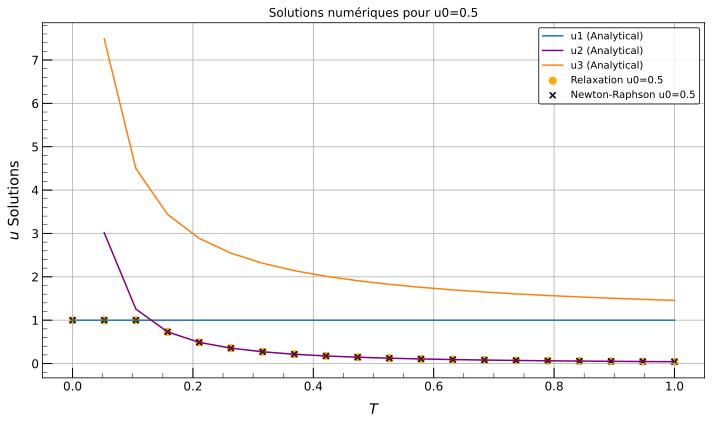

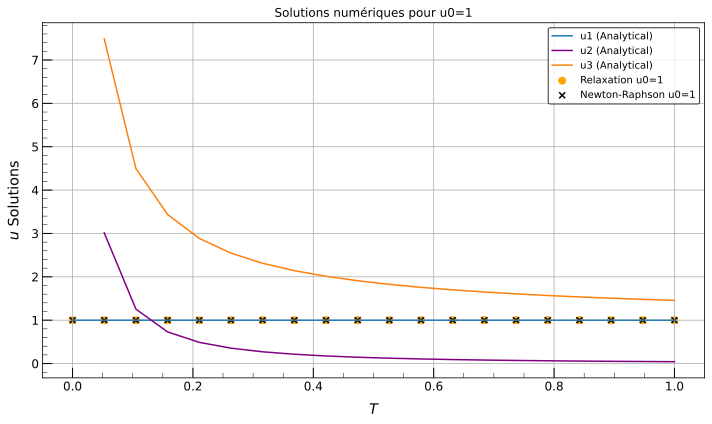

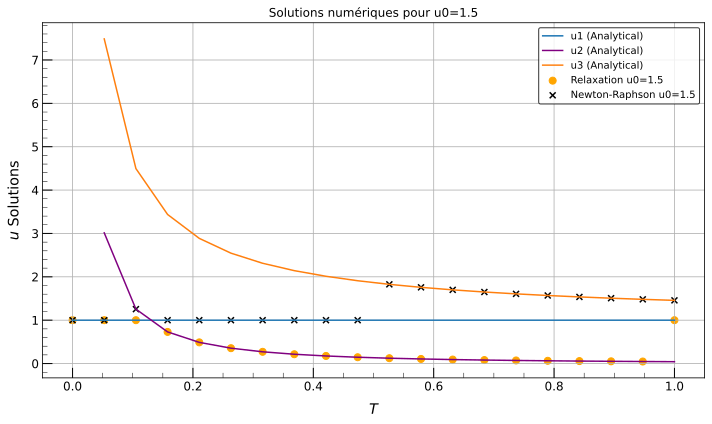

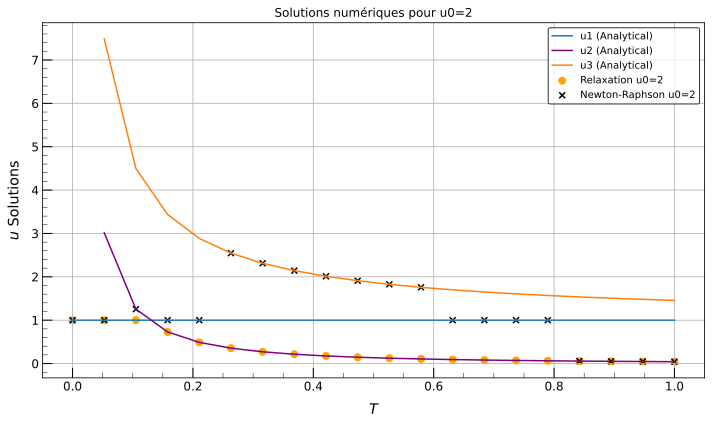

C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:106: RuntimeWarning: invalid value encountered in divide
  return (2*T**2 + T - 2 * np.sqrt(T**4 + T**3)) / (4*T**2)
C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:109: RuntimeWarning: invalid value encountered in divide
  return (2*T**2 + T + 2 * np.sqrt(T**4 + T**3)) / (4*T**2)
C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:74: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda u: equation(T, u), u, dx=1e-6)


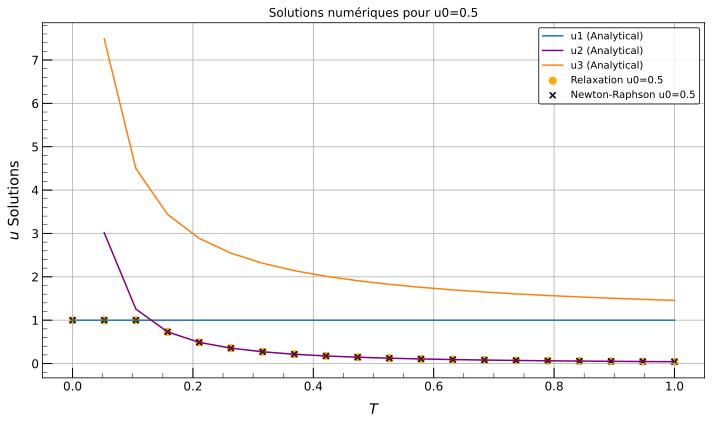

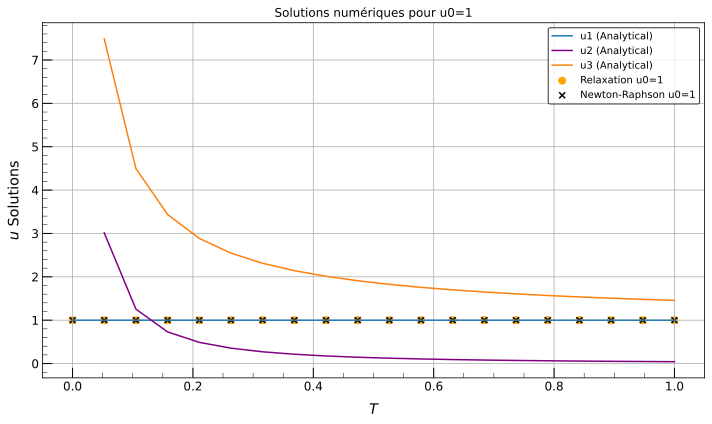

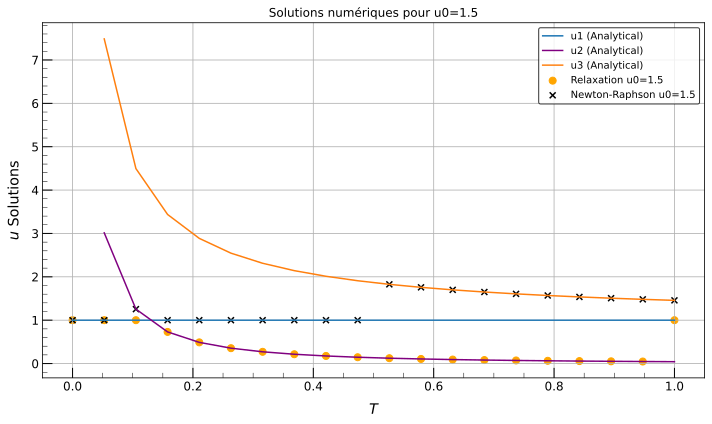

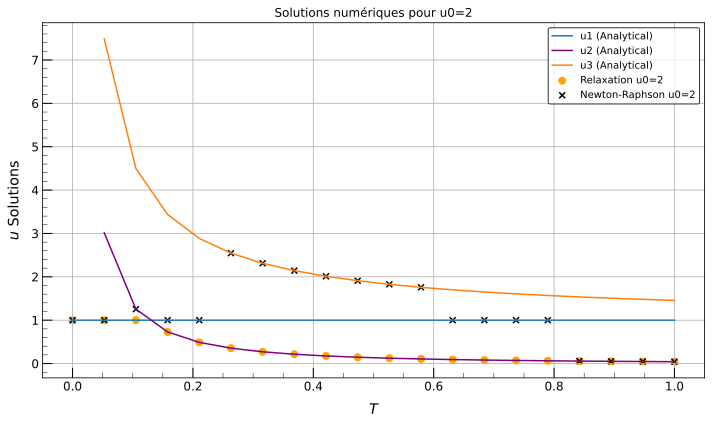

In [3]:
# Equation (2.3.3) et sa dérivée par rapport à u
def equation(T, u):
    return u - 1 / (1 + T * 4 * (1 - u))**2

def equation_derivative(T, u):
    return derivative(lambda u: equation(T, u), u, dx=1e-6)

# Méthode par relaxation
def relaxation_method(T, u0, max_iter=1000, tol=1e-6):
    u = u0
    for _ in range(max_iter):
        u_new = 1 / (1 + T * 4 * (1 - u))**2
        if abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

# Méthode de Newton-Raphson
def newton_raphson_method(T, u0=10, max_iter=1000, tol=1e-6):
    u = u0
    for _ in range(max_iter):
        f_u = equation(T, u)
        df_u = equation_derivative(T, u)
        u_new = u - f_u / df_u
        if abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

# Générer 20 valeurs de T uniformément distribuées dans l'intervalle [0, 1]
T_values = np.linspace(0, 1, 20)

# Définition des fonctions u1, u2 et u3
def u1(T):
    return np.ones_like(T)

def u2(T):
    return (2*T**2 + T - 2 * np.sqrt(T**4 + T**3)) / (4*T**2)

def u3(T):
    return (2*T**2 + T + 2 * np.sqrt(T**4 + T**3)) / (4*T**2)

# Définir différentes valeurs initiales de u0
u0_values = [0.5, 1, 1.5, 2]

# Tracé des solutions pour chaque valeur de u0
for idx, u0 in enumerate(u0_values):
    plt.figure(figsize=(10, 6))
    
    # Tracer les solutions analytiques
    plt.plot(T_values, u1(T_values), label='u1 (Analytical)')
    plt.plot(T_values, u2(T_values), label='u2 (Analytical)', color='purple')
    plt.plot(T_values, u3(T_values), label='u3 (Analytical)')
    
    # Tracer les solutions numériques pour la méthode de relaxation
    relaxation_results = [relaxation_method(T, u0) for T in T_values]
    plt.scatter(T_values, relaxation_results, label=f'Relaxation u0={u0}', color='orange', s=50)
    
    # Tracer les solutions numériques pour la méthode de Newton-Raphson
    newton_results = [newton_raphson_method(T, u0) for T in T_values]
    plt.scatter(T_values, newton_results, marker='x', label=f'Newton-Raphson u0={u0}', color='black')
    
    plt.xlabel('$T$')
    plt.ylabel('$u$ Solutions')
    plt.title(f'Solutions numériques pour u0={u0}')
    plt.legend()
    plt.grid(True)
    plt.show()
# Equation (2.3.3) et sa dérivée par rapport à u
def equation(T, u):
    return u - 1 / (1 + T * 4 * (1 - u))**2

def equation_derivative(T, u):
    return derivative(lambda u: equation(T, u), u, dx=1e-6)

# Méthode par relaxation
def relaxation_method(T, u0, max_iter=1000, tol=1e-6):
    u = u0
    for _ in range(max_iter):
        u_new = 1 / (1 + T * 4 * (1 - u))**2
        if abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

# Méthode de Newton-Raphson
def newton_raphson_method(T, u0=10, max_iter=1000, tol=1e-6):
    u = u0
    for _ in range(max_iter):
        f_u = equation(T, u)
        df_u = equation_derivative(T, u)
        u_new = u - f_u / df_u
        if abs(u_new - u) < tol:
            return u_new
        u = u_new
    return u

# Générer 20 valeurs de T uniformément distribuées dans l'intervalle [0, 1]
T_values = np.linspace(0, 1, 20)

# Définition des fonctions u1, u2 et u3
def u1(T):
    return np.ones_like(T)

def u2(T):
    return (2*T**2 + T - 2 * np.sqrt(T**4 + T**3)) / (4*T**2)

def u3(T):
    return (2*T**2 + T + 2 * np.sqrt(T**4 + T**3)) / (4*T**2)

# Définir différentes valeurs initiales de u0
u0_values = [0.5, 1, 1.5, 2]

# Tracé des solutions pour chaque valeur de u0
for idx, u0 in enumerate(u0_values):
    plt.figure(figsize=(10, 6))
    
    # Tracer les solutions analytiques
    plt.plot(T_values, u1(T_values), label='u1 (Analytical)')
    plt.plot(T_values, u2(T_values), label='u2 (Analytical)', color='purple')
    plt.plot(T_values, u3(T_values), label='u3 (Analytical)')
    
    # Tracer les solutions numériques pour la méthode de relaxation
    relaxation_results = [relaxation_method(T, u0) for T in T_values]
    plt.scatter(T_values, relaxation_results, label=f'Relaxation u0={u0}', color='orange', s=50)
    
    # Tracer les solutions numériques pour la méthode de Newton-Raphson
    newton_results = [newton_raphson_method(T, u0) for T in T_values]
    plt.scatter(T_values, newton_results, marker='x', label=f'Newton-Raphson u0={u0}', color='black')
    
    plt.xlabel('$T$')
    plt.ylabel('$u$ Solutions')
    plt.title(f'Solutions numériques pour u0={u0}')
    plt.legend()
    plt.grid(True)
    plt.show()


Lors de l'application des méthodes numériques de relaxation et de Newton-Raphson pour résoudre l'équation (2.3.3) sur un intervalle de valeurs de T uniformément distribuées, plusieurs observations intéressantes ont été faites. Tout d'abord, lorsque nous avons choisi une valeur initiale de 0.5, les deux méthodes ont convergé vers les valeurs de solution valides les plus proches, ce qui est cohérent avec le comportement attendu des méthodes itératives. Cela confirme que pour des valeurs initiales proches des solutions valides, les méthodes numériques tendent à converger vers ces solutions. Cependant, des comportements divergents ont été observés lorsque la valeur initiale  a été modifiée. Lorsque celle-ci était égal à 1, les deux méthodes semblaient converger vers la première solution où u = 1, même si d'autres solutions valides étaient disponibles. Cette convergence vers une solution spécifique peut être attribuée à la proximité de la valeur initiale avec cette solution, montrant ainsi la sensibilité des méthodes numériques au choix des valeurs initiales. De manière intéressante, pour des valeurs initiales supérieures à 1, la méthode de relaxation semblait converger vers les solutions valides, tandis que la méthode de Newton-Raphson présentait un comportement plus complexe. Certains points de la méthode de Newton-Raphson semblaient être une combinaison des 3 valeurs possibles de u. Cela suggère que la méthode de Newton-Raphson peut être plus sensible aux conditions initiales et peut présenter un comportement oscillant lorsque la fonction à résoudre présente des caractéristiques non linéaires complexes. Il est donc possible d'obtenir les trois solutions identifiées en $\textbf{A}$, mais cela dépend des valeurs initiales choisies. Regardons maintenant le tracé des itérations successives de chacune
des méthodes afin d’illustrer la manière dont elles convergent vers l’une ou l’autre des solutions :

C:\Users\emili\AppData\Local\Temp\ipykernel_9228\484316331.py:74: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda u: equation(T, u), u, dx=1e-6)


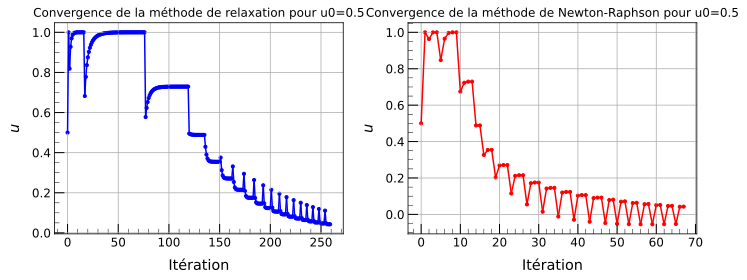

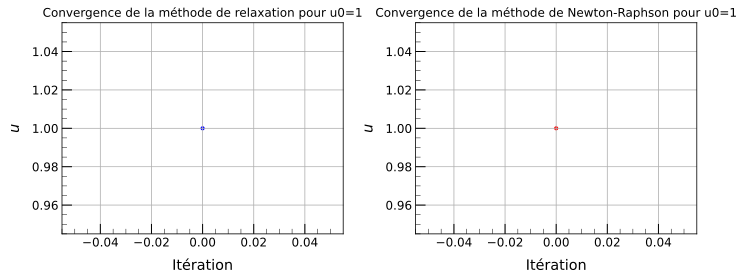

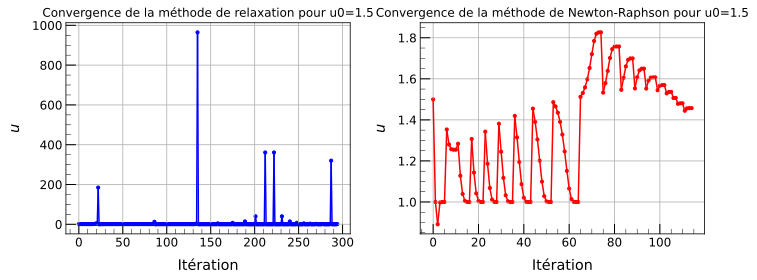

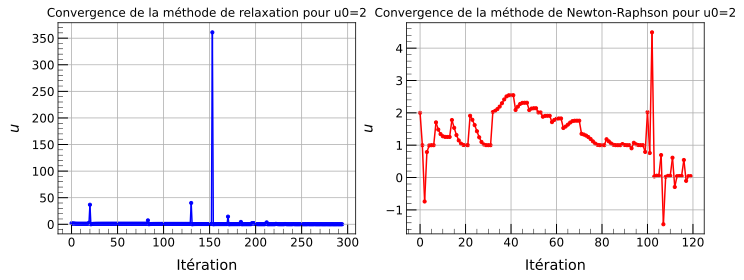

In [4]:
# Fonction pour calculer les itérations successives de la méthode de relaxation
def relaxation_method_iterations(T_values, u0, max_iter=1000, tol=1e-6):
    u_iterations = [u0]
    for T in T_values:
        u = u0
        for _ in range(max_iter):
            u_new = 1 / (1 + T * 4 * (1 - u))**2
            if abs(u_new - u) < tol:
                break
            u = u_new
            u_iterations.append(u_new)
    return u_iterations

# Fonction pour calculer les itérations successives de la méthode de Newton-Raphson
def newton_raphson_method_iterations(T_values, u0=10, max_iter=1000, tol=1e-6):
    u_iterations = [u0]
    for T in T_values:
        u = u0
        for _ in range(max_iter):
            f_u = equation(T, u)
            df_u = equation_derivative(T, u)
            u_new = u - f_u / df_u
            if abs(u_new - u) < tol:
                break
            u = u_new
            u_iterations.append(u_new)
    return u_iterations

# Tracé des itérations successives pour chaque méthode
for idx, u0 in enumerate(u0_values):
    plt.figure(figsize=(10, 4))

    # Méthode de relaxation
    plt.subplot(1, 2, 1)
    relaxation_iterations = relaxation_method_iterations(T_values, u0)
    for i in range(len(relaxation_iterations) - 1):
        plt.plot([i, i + 1], [relaxation_iterations[i], relaxation_iterations[i + 1]], color='blue')
    plt.scatter(range(len(relaxation_iterations)), relaxation_iterations, color='blue', label='Relaxation', s=10)
    plt.xlabel('Itération')
    plt.ylabel('$u$')
    plt.title(f'Convergence de la méthode de relaxation pour u0={u0}')
    plt.grid(True)

    # Méthode de Newton-Raphson
    plt.subplot(1, 2, 2)
    newton_iterations = newton_raphson_method_iterations(T_values, u0)
    for i in range(len(newton_iterations) - 1):
        plt.plot([i, i + 1], [newton_iterations[i], newton_iterations[i + 1]], color='red')
    plt.scatter(range(len(newton_iterations)), newton_iterations,color='red', label='Newton-Raphson', s=10)
    plt.xlabel('Itération')
    plt.ylabel('$u$')
    plt.title(f'Convergence de la méthode de Newton-Raphson pour u0={u0}')
    plt.grid(True)

    plt.tight_layout(pad=5)  # Séparation supplémentaire entre les sous-graphiques
    plt.show()

Comme mentionné précédemment, lorsque les valeurs initiales sont judicieusement choisies, les deux méthodes, relaxation et Newton-Raphson, convergent rapidement vers la solution souhaitée (par exemple, avec u0=0.5). Cela souligne l'importance de la proximité de la valeur initiale à la solution véritable dans la facilitation d'une convergence efficace. Si la valeur initiale est proche d'une valeur que la fonction peut prendre, les méthodes tendent à converger vers cette solution. Cela peut être avantageux lorsque la solution initiale est proche de la solution souhaitée mais peut également entraîner une convergence vers des solutions non désirées si la valeur initiale est proche d'autres solutions possibles de l'équation (par exemple, avec u0=1). Enfin, en observant le tracé des itérations pour une valeur initiale qui s'éloigne considérablement des solutions attendues, on observe des comportements oscillatoires ou divergents dans les itérations des deux méthodes.